Inspired in: https://playground.tensorflow.org/

In [1]:
using Pkg
Pkg.activate("..")

  Activating environment at `E:\Projects\OCDNN.jl\Project.toml`


In [2]:
using Revise
using OCDNN, Printf, Random, Serialization, Plots

In [54]:
gr()

Plots.GRBackend()

In [55]:
function in_dir(f, path::String)
    current = pwd()
    cd(path)
    f()
    cd(current)
end

in_dir (generic function with 1 method)

In [56]:
Random.seed!(1234)
dataset = build_dataset(N_samples = 50, N_noise = 5);
data, feat = dataset;

In [57]:
N,d = size(data);

In [58]:
idxs = feat .== 1;

In [59]:
Cs = get_color_palette(:tab10, plot_color(:white));

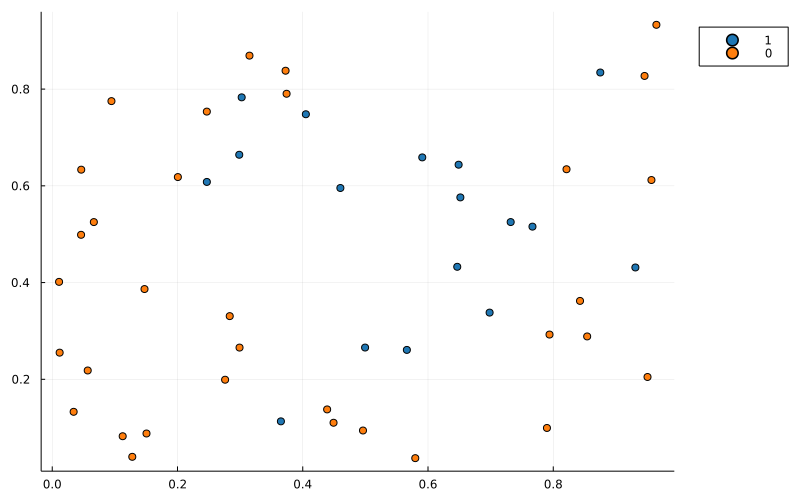

In [60]:
p = Plots.plot(size= (800,500), legend = :outertopright)
Plots.scatter!(p,data[:,1][idxs],data[:,2][idxs], label = "1", c = Cs[1])
Plots.scatter!(p,data[:,1][.!idxs],data[:,2][.!idxs], label = "0", c = Cs[2])

In [61]:
nlayers = 6
channels = 2 # number of neurons per layer
niter = 10000
τ=0.1;
τ_max=10;
stepsize = 0.1;

In [62]:
A_eu = reshape([0],(1,1));
w_eu = [1];
A_ie = [0 0; 1 0];
w_ie = [0.5 ;0.5];
A_kutta4 = [0 0 0 0;0.5 0 0 0;0 0.5 0 0;0 0 1 0];
w_kutta4 = 1/6*[1;2;2;1];
A_kutta3 = [0 0 0;1/2 0 0;-1 2 0];
w_kutta3 = [1/6;2/3;1/6];

In [63]:
rk4 = OCDNN.ExplicitRungeKutta(A_kutta4,w_kutta4,"RK4");
rk3 = OCDNN.ExplicitRungeKutta(A_kutta3,w_kutta3,"RK3");
rk2 = OCDNN.ExplicitRungeKutta(A_ie,w_ie,"RK2");
euler = OCDNN.ExplicitRungeKutta(A_eu,w_eu,"Euler");
rks = [euler,rk2,rk3,rk4];

In [64]:
names = [rk.name for rk in rks];

In [65]:
eta = x -> exp(x)/(exp(x)+1)

#49 (generic function with 1 method)

In [66]:
problem = OCDNN.Problem(tanh, eta, feat);

In [67]:
final_string = string(nlayers)*"_layers_"*string(N)*"_points_"*string(channels)*"_channels"
traineddir = "..\\train\\Classification\\"*final_string*".tmp"
all_results = deserialize(traineddir);

In [68]:
final_string = string(nlayers)*"_layers_"*string(N)*"_points_"*string(channels)*"_channels"
outputdir = "..\\images\\Classification\\"*final_string
if !isdir(outputdir)
    mkdir(outputdir)
end

In [69]:
all_Ctrls,all_logs = first.(all_results),last.(all_results);

In [70]:
names = ["Euler" "RK2" "RK3" "RK4"]

1×4 Matrix{String}:
 "Euler"  "RK2"  "RK3"  "RK4"

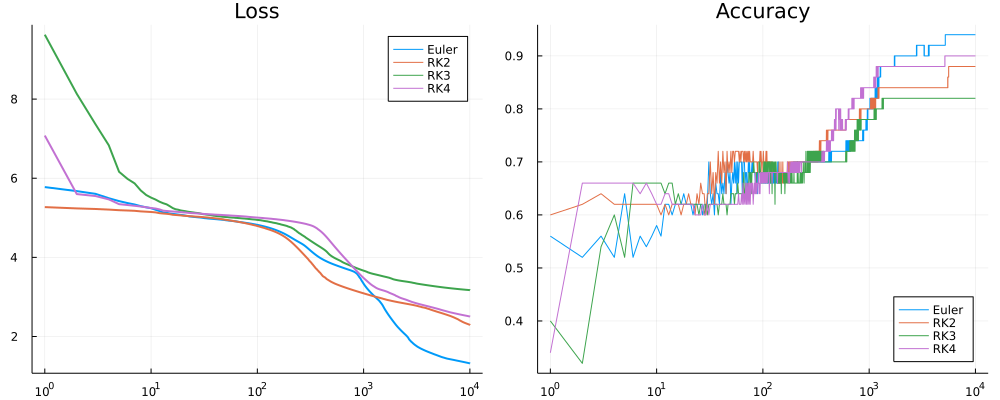

In [71]:
p1 = Plots.plot([all_logs[i].loss for i in 1:4], xaxis = :log10, label = names, linewidth=2, legend= :topright)
p2 = Plots.plot([all_logs[i].accuracy for i in 1:4], xaxis = :log10, label = names, legend= :bottomright)
Plots.plot(p1,p2, title = ["Loss" "Accuracy"], size = (1000,400))

In [72]:
in_dir(outputdir) do
    Plots.savefig("loss_acc_rks_"*final_string*".pdf")
end

In [73]:
all_times = [sum(all_logs[i].time) for i in 1:4];

In [74]:
CS = get_color_palette(:auto, plot_color(:white))
all_cs = [CS[i] for i in 1:4];

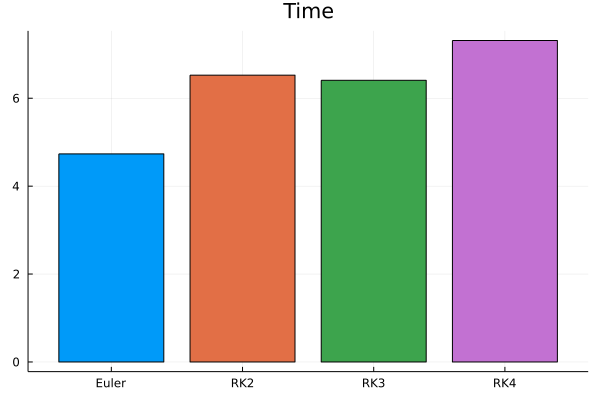

In [75]:
Plots.bar(all_times, xticks = (1:4,names), title = "Time", legend = :none, fillcolor = all_cs)

In [76]:
in_dir(outputdir) do
    Plots.savefig("time_rks_"*final_string*".pdf")
end

In [77]:
all_Ctrls_test = deepcopy.(all_Ctrls);

In [78]:
xs = collect(0:0.002:1)
ys = collect(0:0.002:1);

In [79]:
Y0_test = [[x,y] for x in xs, y in ys];

In [80]:
for i in 1:4
    all_Ctrls_test[i].Y0 = hcat(Y0_test...)';
end

In [81]:
classifiers = [[] for i in 1:4]
for i in 1:4
    classifiers[i] = OCDNN.RKforwardstepper(all_Ctrls_test[i],rks[i],problem).Classifier;
end

In [82]:
value = [reshape(round.(classifiers[i]), size(Y0_test))' for i in 1:4];

In [88]:
Cs1 = get_color_palette(:tab10, plot_color(:white));

In [89]:
p = []
for i in 1:4
    pi = Plots.plot(title = names[i], legend = :none, axis = false, ticks = false)
    Plots.contour!(pi,xs,ys, value[i], fill = true, c = [Cs1[2],Cs1[1]])
    Plots.scatter!(pi,data[:,1][idxs],data[:,2][idxs], c = Cs1[1])
    Plots.scatter!(pi,data[:,1][.!idxs],data[:,2][.!idxs], c = Cs1[2])
    Plots.plot!(pi, t->0.3sin(t)+0.5,t->0.3cos(t)+0.5, 0, 2π, legend=false, linewidth=3, c = Cs1[3])
    push!(p,pi)
end
Plots.plot(p..., size=(900,600))

In [90]:
in_dir(outputdir) do
    Plots.savefig("contour_plots_rks_"*final_string*".pdf")
end